# Proyecto 2:

Integrantes:
* Ayelen Catacora Juanillo
* Dario Toribio López





# Librerías:

In [63]:
import math
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, rand_score, adjusted_mutual_info_score
import matplotlib.pyplot as plt
import pywt
import pywt.data
from  skimage.io import imread, imshow
import numpy as np
import pandas as pd
import os
from sklearn import datasets
import random
from collections import Counter

# Load Data:

In [8]:
def  Get_Feacture(picture, cortes):
  LL = picture
  for i in range(cortes):
     LL, (LH, HL, HH) = pywt.dwt2(LL, 'haar')
  return LL.flatten()

In [74]:
carpetas= ['anger', 'surprise', 'happy', 'fear', 'disgust', 'sadness', 'contempt']
dataset=[]
etiquetas = []
rpath='Base/'
lab = 1
for i in carpetas:
  for file in os.listdir(rpath + i):
    picture = imread(rpath + i + "/" + file)
    dataset.append(np.array(Get_Feacture(picture,2)))
    etiquetas.append(lab)
  lab+=1
dataset = np.array(dataset)
print(dataset.shape)

(981, 144)


## Reducción de la dimensionalidad

Text(0, 0.5, 'cumulative explained variance')

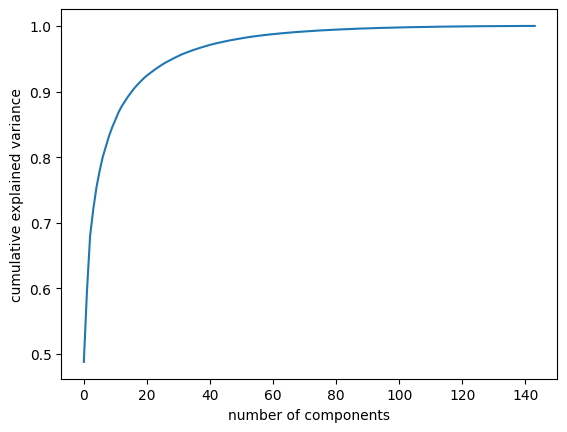

In [28]:
pca = PCA().fit(dataset)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

Para este caso tenemos que el codo de la gráfica se encuentra alrededor del valor 34 de componentes, por lo que reduciremos la dimensión de los vectores característicos a este.

In [27]:
pca = PCA(n_components=34)
pca.fit(dataset)
data_pca = pca.transform(dataset)
print(data_pca.shape)

(981, 34)


# Algoritmos

## K-Means

In [14]:
def init_centroides(data, k):
    indices=np.random.choice(len(data), k, replace=False)
    centroides=data[indices]
    return centroides

In [15]:
def asignar_puntos_centroides(data, centroides):
    d=np.sqrt(((data-centroides[:, np.newaxis])**2).sum(2))
    clusters=np.argmin(d, axis=0)
    return clusters

In [16]:
def update_centroides(data, clusters, k):
    neew_centroides=np.array([data[clusters==i].mean(axis=0) for i in range(k)])
    return neew_centroides

In [18]:
def kmeans(data, k, max_iteraciones):
    centroides=init_centroides(data, k)
    iteracion=0
    while iteracion<max_iteraciones:
        clusters=asignar_puntos_centroides(data, centroides)
        new_centroides=update_centroides(data, clusters, k)
        if np.all(centroides==new_centroides):
            break
        centroides=new_centroides
        iteracion+=1
    return clusters,centroides

## DBSCAN

In [55]:
def distancia(a, b):
    d=0
    for i in range(len(a)):
        d+=(a[i] - b[i]) ** 2
    return math.sqrt(d)

In [56]:
def obtener_vecinos(data, point_index, epsilon):
    vecinos=[]
    for i in range(len(data)):
        if distancia(data[point_index], data[i])<=epsilon:
            vecinos.append(i)
    return vecinos

In [57]:
def expand_clusters(data, etiquetas, point_index, vecinos, cluster_id, epsilon, min_samples):
    etiquetas[point_index] = cluster_id
    i = 0
    while i < len(vecinos):
        current_point_index = vecinos[i]
        if etiquetas[current_point_index] == -1:
            etiquetas[current_point_index] = cluster_id
        elif etiquetas[current_point_index] == 0:
            etiquetas[current_point_index] = cluster_id
            current_point_neighbors = obtener_vecinos(data, current_point_index, epsilon)
            if len(current_point_neighbors) >= min_samples:
                vecinos += current_point_neighbors
        i += 1

In [58]:
def DBSCAN(data, epsilon, minimo_vecinos): 
    num_points = len(data)
    etiquetas = [0] * num_points
    cluster_id = 0

    for point_index in range(num_points):
        if etiquetas[point_index] != 0:
            continue
        vecinos = obtener_vecinos(data, point_index, epsilon)
        if len(vecinos) < minimo_vecinos:
            etiquetas[point_index] = -1  #ruido
        else:
            cluster_id += 1
            expand_clusters(data, etiquetas, point_index, vecinos, cluster_id, epsilon, minimo_vecinos)

    return etiquetas

## GMM

In [64]:
from sklearn.mixture import GaussianMixture

# Metricas

In [72]:
def metricas(clusters, clusters_pca, labels, dataset, data_pca):
    scores = {
        "Normal": np.array([silhouette_score(dataset, clusters), 
                            rand_score(labels, clusters),
                            adjusted_mutual_info_score(labels, clusters)]),
        "PCA": np.array([silhouette_score(data_pca, clusters_pca), 
                            rand_score(labels, clusters_pca),
                            adjusted_mutual_info_score(labels, clusters_pca)])
    }
    return pd.DataFrame.from_dict(scores, orient="index", columns=["Silhouette", "Rand", "Adjust Mutual Information"])

# Experimentación

## K-Means

In [111]:
parametros_k = {1000: [], 5000: [], 10000: []}
ks = [5, 6, 7, 8, 9]
for it in parametros_k:
    for k in ks:
        clusters, _ = kmeans(dataset, k, it)
        temp = []
        temp.append(k)
        temp.append(clusters)
        parametros_k[it].append(temp)

In [112]:
parametros_k_pca = {1000: [], 5000: [], 10000: []}
ks = [5, 6, 7, 8, 9]
for it in parametros_k_pca:
    for k in ks:
        clusters, _ = kmeans(data_pca, k, it)
        temp = []
        temp.append(k)
        temp.append(clusters)
        parametros_k_pca[it].append(temp)

## DBSCAN

In [119]:
epsilons = {1200: [],  1250: [], 1300: [], 1350: [], 1400: []}
vecinos = [2, 4, 6, 8, 10]
for e in epsilons:
  for v in vecinos:
    clusters = DBSCAN(dataset, e, v)
    temp = []
    temp.append(v)
    temp.append(clusters)
    epsilons[e].append(temp)

In [121]:
epsilons_pca = {1200: [],  1250: [], 1300: [], 1350: [], 1400: []}
vecinos = [2, 4, 6, 8, 10]
for e in epsilons_pca:
  for v in vecinos:
    clusters = DBSCAN(data_pca, e, v)
    temp = []
    temp.append(v)
    temp.append(clusters)
    epsilons_pca[e].append(temp)

## GMM

In [96]:
components = {5: [], 6: [], 7: [], 8: [], 9: []}
for c in components:
    gmm = GaussianMixture(n_components=c)
    gmm.fit(dataset)
    components[c] = gmm.predict(dataset)

In [95]:
components_pca = {5: [], 6: [], 7: [], 8: [], 9: []}
for c in components_pca:
    gmm = GaussianMixture(n_components=c)
    gmm.fit(data_pca)
    components_pca[c] = gmm.predict(data_pca)

# Resultados

## K-Means

In [122]:
for parametro in parametros_k:
    print("Iteraciones: ", parametro)
    for i in range(len(parametros_k[parametro])):
        print("k: ", parametros_k[parametro][i][0])
        r = metricas(parametros_k[parametro][i][1], parametros_k_pca[parametro][i][1], etiquetas, dataset, data_pca)
        print(r)

Iteraciones:  1000
k:  5
        Silhouette      Rand  Adjust Mutual Information
Normal    0.140707  0.671037                   0.028945
PCA       0.123707  0.686817                   0.036995
k:  6
        Silhouette      Rand  Adjust Mutual Information
Normal    0.148257  0.707493                   0.047210
PCA       0.149064  0.708392                   0.033537
k:  7
        Silhouette      Rand  Adjust Mutual Information
Normal    0.116673  0.734575                   0.066626
PCA       0.153848  0.727677                   0.033766
k:  8
        Silhouette      Rand  Adjust Mutual Information
Normal    0.138992  0.718561                   0.039210
PCA       0.140506  0.742148                   0.057013
k:  9
        Silhouette      Rand  Adjust Mutual Information
Normal    0.161059  0.742462                   0.058950
PCA       0.122184  0.752244                   0.045583
Iteraciones:  5000
k:  5
        Silhouette      Rand  Adjust Mutual Information
Normal    0.140221  0.686598  

## DBSCAN

In [123]:
for ep in epsilons:
    print("Epsilon: ", ep)
    for i in range(len(epsilons[ep])):
        print("vecinos: ", epsilons[ep][i][0])
        r = metricas(epsilons[ep][i][1], epsilons_pca[ep][i][1], etiquetas, dataset, data_pca)
        print(r)

Epsilon:  1200
vecinos:  2
        Silhouette      Rand  Adjust Mutual Information
Normal    0.335611  0.789103                   0.148871
PCA       0.102398  0.671054                   0.120010
vecinos:  4
        Silhouette      Rand  Adjust Mutual Information
Normal    0.130595  0.771073                   0.113715
PCA      -0.012347  0.666373                   0.102006
vecinos:  6
        Silhouette      Rand  Adjust Mutual Information
Normal    0.106450  0.762914                   0.105453
PCA      -0.020847  0.663902                   0.097203
vecinos:  8
        Silhouette      Rand  Adjust Mutual Information
Normal   -0.022353  0.691616                   0.075165
PCA      -0.068087  0.638524                   0.061224
vecinos:  10
        Silhouette      Rand  Adjust Mutual Information
Normal   -0.099251  0.608729                   0.063649
PCA      -0.065397  0.637891                   0.054220
Epsilon:  1250
vecinos:  2
        Silhouette      Rand  Adjust Mutual Information
N

## GMM

In [118]:
for c in components:
    r = metricas(components[c], components_pca[c], etiquetas, dataset, data_pca)
    print(c, "componentes")
    print(r)

5 componentes
        Silhouette      Rand  Adjust Mutual Information
Normal    0.145902  0.680120                   0.043470
PCA       0.160512  0.679733                   0.040081
6 componentes
        Silhouette      Rand  Adjust Mutual Information
Normal    0.121120  0.718066                   0.039372
PCA       0.152248  0.712844                   0.081593
7 componentes
        Silhouette      Rand  Adjust Mutual Information
Normal    0.149814  0.724735                   0.045786
PCA       0.168502  0.729058                   0.060349
8 componentes
        Silhouette      Rand  Adjust Mutual Information
Normal    0.145369  0.727458                   0.046670
PCA       0.156655  0.744719                   0.065162
9 componentes
        Silhouette      Rand  Adjust Mutual Information
Normal    0.143807  0.747238                   0.056628
PCA       0.154207  0.752722                   0.059581
